In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "18_01_2024",
                'genotype_dir': 'ER4d_sytjGCaMP7f_attp2',
                'fly': 'fly3',
                'session': 'closed_loop-002',
                'full_genotype': '+/w-; +/ER4d-AD; UAS-sytjGCaMP7f^{attp2}/ER4d-DBD (SS00238)',
                'ecl date': '1/11/2024' }

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)

In [4]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
nap = pp.open_napari()

(222, 293)
[########################################] | 100% Completed | 34.42 s


In [5]:
print('next')

next


In [6]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [7]:
y = pp.calculate_zscored_F('rois') #, exp_detrend=False)

In [8]:
pp.save()

In [3]:
if True:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]

In [10]:
y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(-y, 1, axis=-1),.7,axis=1, mode='wrap')
# y_sm = -y

In [11]:
x_f,y_f = st2p.utilities.pol2cart(y_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(2463,) (2463,)


(array([702., 918., 554., 205.,  55.,  14.,   4.,   6.,   1.,   4.]),
 array([0.00321955, 0.12487999, 0.24654042, 0.36820086, 0.4898613 ,
        0.61152173, 0.73318217, 0.85484261, 0.97650304, 1.09816348,
        1.21982392]),
 <BarContainer object of 10 artists>)

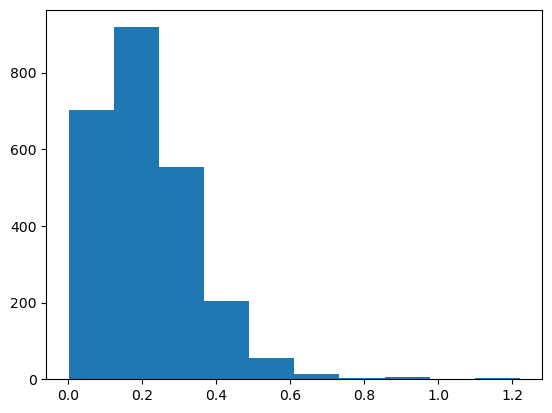

In [12]:
fig, ax = plt.subplots()
ax.hist(rho)

0.19634954084936207


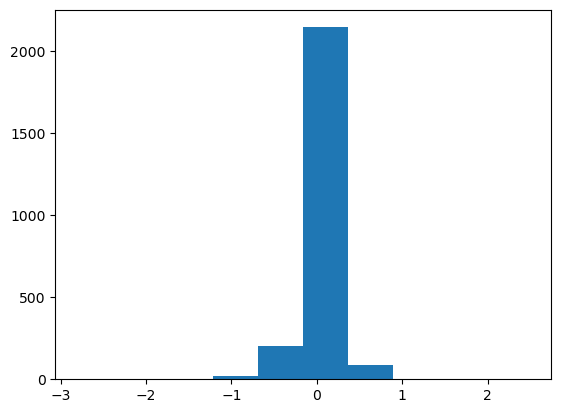

In [20]:
dh = np.ediff1d(heading, to_end=0)
_, dh = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones_like(heading), dh))
# dh[:-1] = np.angle(np.exp(1j*heading[1:])*np.exp(1j*heading[:-1]))
fig, ax = plt.subplots()
ax.hist(dh)
rot_mask = np.abs(dh)>np.pi/32
print(np.pi/16)

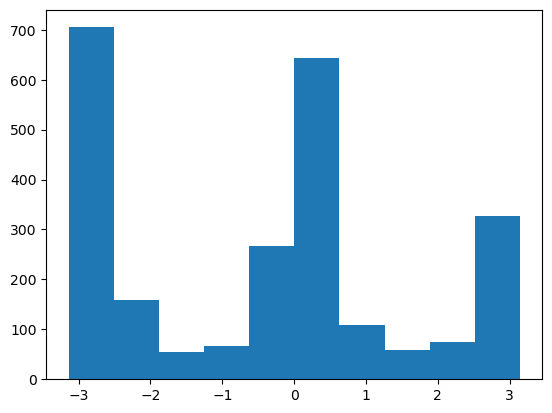

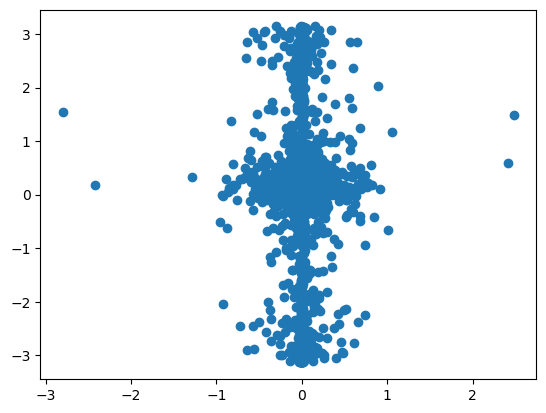

In [21]:
dphi = np.ediff1d(phi, to_end=0)
_, dphi = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones_like(heading), phi))

fig, ax = plt.subplots()
ax.hist(dphi)

# _mask = np.abs(dphi)<np.pi/2
fig, ax = plt.subplots()
ax.scatter(dh, dphi)

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(1, 16, 2463) (2463,)


(array([17., 26., 55., 89., 86., 64., 73., 57., 31., 21.]),
 array([-3.13798919, -2.51462485, -1.8912605 , -1.26789616, -0.64453181,
        -0.02116746,  0.60219688,  1.22556123,  1.84892557,  2.47228992,
         3.09565426]),
 <BarContainer object of 10 artists>)

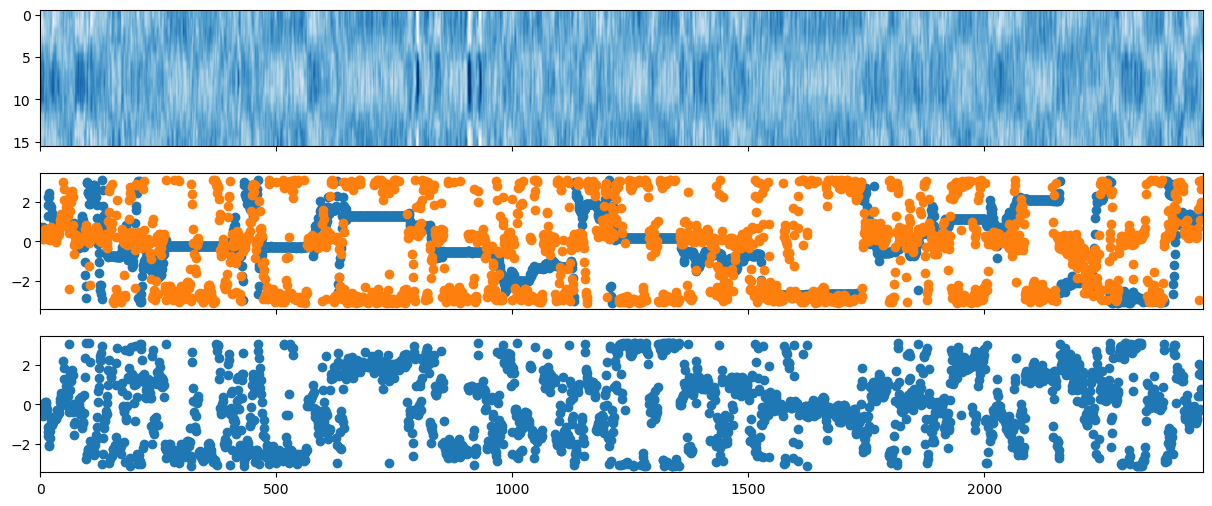

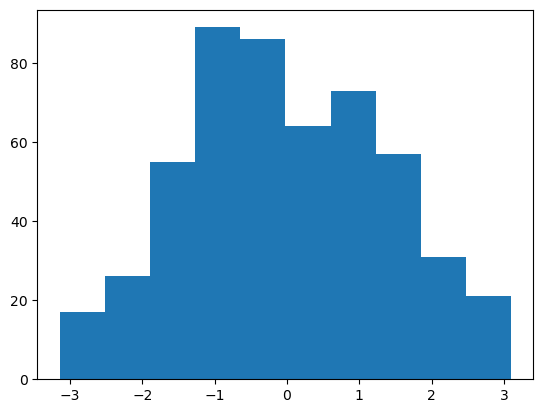

In [22]:
fig, ax= plt.subplots(3,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm[0,:,:] - y_sm[0,:,:].mean(axis=0), aspect='auto', cmap= 'Blues', vmin=-2, vmax=2)
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[1].scatter(x,heading)
ax[1].scatter(x, phi)
ax[2].scatter(x, offset)

mask = (heading>-3*np.pi/4) & (heading<3*np.pi/4)
fig, ax= plt.subplots()
ax.hist(offset[mask*rot_mask])

(16,) (16,)


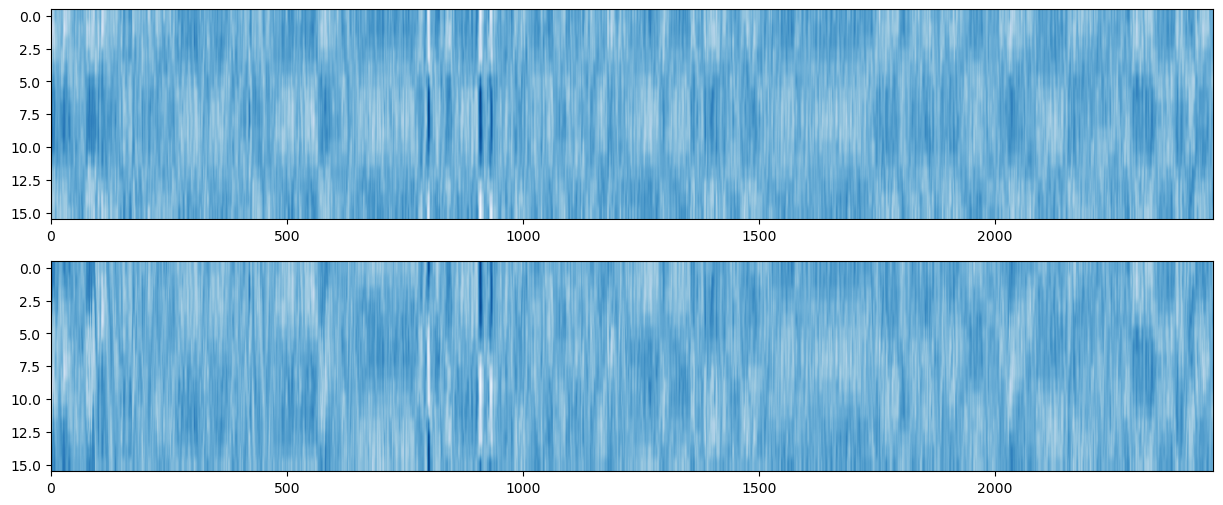

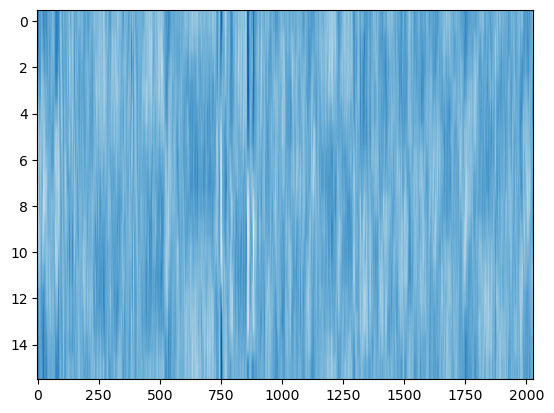

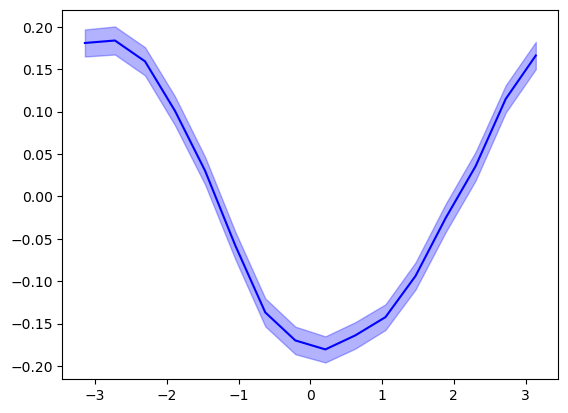

In [23]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)
# print(heading_ind, y_sm.shape)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[0,:,ind] = np.roll(y_sm[0,:,ind], -heading_ind[ind])
    
# y_sm_heading_aligned = y_sm_heading_aligned/np.linalg.norm(y_sm_heading_aligned, axis=1)
y_sm_heading_aligned = y_sm_heading_aligned - y_sm_heading_aligned.mean(axis=1)

fig, ax= plt.subplots(2,1, figsize=[15,6])
ax[0].imshow(y_sm[0,:, :] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')
ax[1].imshow(y_sm_heading_aligned[0,:,:], cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,mask*rot_mask].mean(axis=-1)[0,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,mask*rot_mask], axis=-1)[0,:]
print(mu.shape, sem.shape)
fig, ax = plt.subplots()
ax.imshow(y_sm_heading_aligned[:,:,mask][0,:,:], cmap='Blues', aspect='auto')

fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')